In [303]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


from encoder import VAE, vae_loss, recon_loss
from plot_fns import *
from utils_data import *
from utils_train import *

set_plt_settings()
%load_ext autoreload
# %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [304]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


## Make data

In [305]:
# make data
N = 300
T = 720
n_nodes = 20
n_series = 3
latent_dim = 20

In [306]:
X = make_fake_data(N, T, n_nodes, n_series)
X = torch.tensor(X, dtype=torch.float)

100%|███████████████████████████████████████| 719/719 [00:00<00:00, 8811.51it/s]

Returning dataset with shape:	 (300, 3, 720, 20)


## train model
-- Add dropout
-- Add more convolutional layers

In [307]:
dataloaders, ds_sizes = make_dataloaders(X, None, batch_size=32)
lr = 1e-3
model = VAE(latent_dim, (n_series, T, n_nodes))
criterion = vae_loss
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
dataset_sizes = ds_sizes

In [308]:
wts, loss_summ = train_model(model, criterion, optimizer, None, dataloaders, ds_sizes, PATH_MODELS, device, 5)

validate epoch: [9/9] Loss: 2101354.4573: 100%|███| 3/3 [00:00<00:00,  7.67it/s]


Returning best model, with validation loss 2101354.4572610296


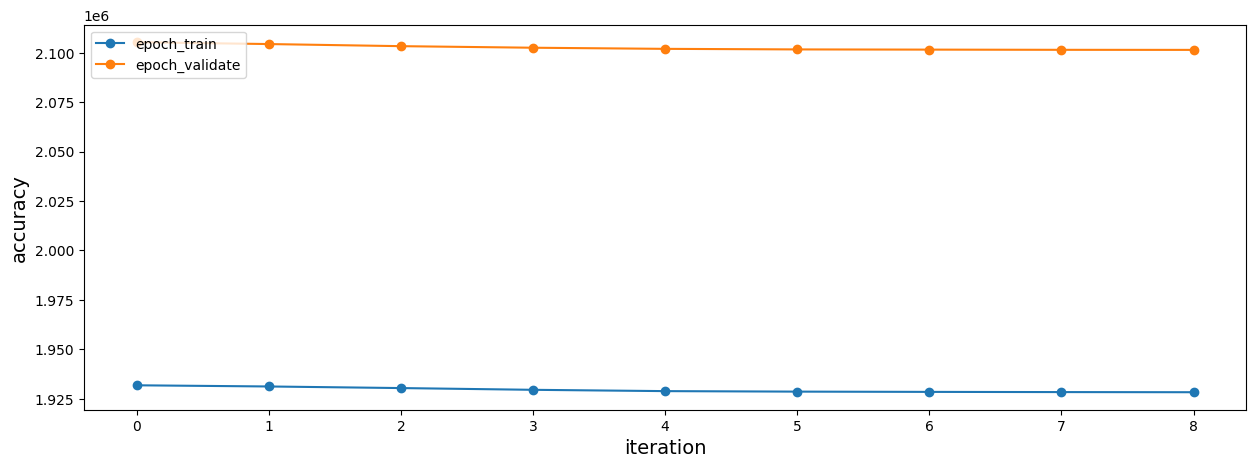

In [309]:
plot_accs({key: loss_summ[key] for key in ['epoch_train', 'epoch_validate']})

In [310]:
model_name = 'testcase'
save_mode = False
# save to file
if save_mode:
    # MODEL
    torch.save(model.state_dict(), PATH_MODELS + f'{model_name}.pt')
    # RESULTS
    filename = f'loss_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(loss_summ[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(PATH_RESULTS + filename)

## Test model

In [311]:
x = X[:1]
model.load_state_dict(wts)
xhat, mu, logvar = model(X[:1])
print(x.shape)
print(xhat.shape)

torch.Size([1, 3, 720, 20])
torch.Size([1, 3, 720, 20])


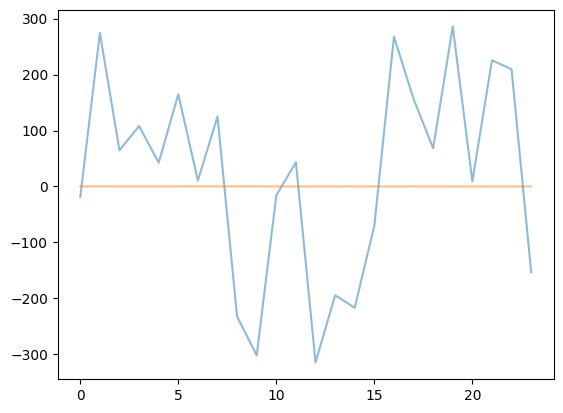

In [312]:
ran = list(range(0, 24))
plt.plot(x[0, 0, ran, 0], alpha=0.5, label='x')
plt.plot(xhat[0,0, ran,0].detach(), alpha=0.5, label='xhat')
plt.show()